<a href="https://colab.research.google.com/github/jagaldol/chat-foodie/blob/dev/chatbot/fine-tuning/KoAlpaca_QLoRA_ChatFoodie_Model_FineTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# koalpaca-Polyglot-ko 5.8B QLoRA 학습으로 chat foodie 모델 만들기

* 4bit quantization 방법을 통해 Colab Free (T4 GPU)에서 한국어 언어 모델 KoAlpaca-Polyglot-ko 5.8B 을 QLoRA로 파인튜닝 한다.
* 이 학습을 통해 만들어지는 chat foodie 모델은 음식 추천 챗봇에 쓰인다.

In [ ]:
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 11.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 4.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.4/492.4 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

## 데이터셋: chatfoodie v1.0

* Fine-Tuning을 위한 도메인 데이터 다운로드
* chatfoodie v1.0은 음식 추천이나 음식 정보 데이터가 대화형으로 만들어진 데이터 셋이다.

In [ ]:
from datasets import load_dataset

# chat-foodie v1.0 데이터셋 다운
data = load_dataset("jagaldol/chat-foodie")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

* 데이터 셋의 개수와 형식을 볼 수 있다.

In [ ]:
data

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output'],
        num_rows: 8218
    })
})

* 데이터를 챗봇에 학습시키기 위한 형식으로 매핑한다.

In [ ]:
data = data.map(
    lambda x: {'text': f"### 질문: {x['instruction']}\n\n### 답변: {x['output']}<|endoftext|>" }
)

Map:   0%|          | 0/8218 [00:00<?, ? examples/s]

## 쪼개진 모델 로드

* 본래 모델은 단일 파일로도 있지만, 작은 파일(약 1GB)로 쪼개서 개별로 로드한 레포를 쓰면 RAM 오류없이 사용할 수 있다.

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

model_id = "beomi/KoAlpaca-Polyglot-5.8B"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=bnb_config, device_map={"":0})

Loading checkpoint shards:   0%|          | 0/13 [00:00<?, ?it/s]

## 텍스트 데이터만 tokenize

In [ ]:
data = data.map(lambda samples: tokenizer(samples["text"]), batched=True)

Map:   0%|          | 0/8218 [00:00<?, ? examples/s]

* 훈련 세트의 첫 번째 데이터 출력

In [ ]:
data['train'][0]['text']

'### 질문: 크리스마스 뭐 먹을까?\n\n### 답변: 치킨을 먹는 건 어떨까요? 치킨은 언제나 맛있어요.<|endoftext|>'

* PEFT를 통해 `prepare_model_for_kbit_training`로 Low bit 학습을 준비한다.

In [ ]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

* 기존 모델 중 학습가능한 파라미터의 수를 출력해주는 함수

In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

* LoRA 파라미터 정의

In [ ]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["query_key_value"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 3670016 || all params: 3070156800 || trainable%: 0.11953838970048696


## 학습하기

* 한 batch에 데이터 8개씩 5150 스텝, 총 41200개의 데이터(약 5 epoch)를 학습한다.
* optim 파라미터의 값으로 들어간 paged_adamw_8bit 방식은 train loss를 0으로 만드는 오류가 있어서 주석처리하였다.

In [ ]:
import transformers

# needed for gpt-neo-x tokenizer
tokenizer.pad_token = tokenizer.eos_token

trainer = transformers.Trainer(
    model=model,
    train_dataset=data["train"],
    args=transformers.TrainingArguments(
        per_device_train_batch_size=8,
        gradient_accumulation_steps=1,
        max_steps=5150,
        learning_rate=1e-4,
        fp16=True,
        logging_steps=10,
        logging_dir="./logs",
        output_dir="outputs",
        # optim="paged_adamw_8bit"
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
10,3.020000
20,2.468900
30,2.330700
40,1.943600
50,1.769400
60,1.716800
70,1.578300
80,1.586500
90,1.607600
100,1.646600


TrainOutput(global_step=5150, training_loss=1.3477942920425563, metrics={'train_runtime': 15689.4351, 'train_samples_per_second': 2.626, 'train_steps_per_second': 0.328, 'total_flos': 9.000732316336128e+16, 'train_loss': 1.3477942920425563, 'epoch': 5.01})

In [21]:
model.eval()
model.config.use_cache = True  # silence the warnings. Please re-enable for inference!

* 모델이 답변을 잘 생성하는지 생성해보기

In [22]:
model.generate(**tokenizer("### 질문: 점심 추천해줘", return_tensors='pt', return_token_type_ids=False))

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


tensor([[    6,     6,     6,  2438,    29,  6231,  3046,   310,  3219,   202,
           202,     6,     6,     6,  4253,    29, 23440,   276,  3046, 10319]])

* 모델의 답변을 받아와 토큰은 해독하는 함수

In [23]:
def gen(x):
    gened = model.generate(
        **tokenizer(
            f"### 질문: {x}\n\n### 답변:",
            return_tensors='pt',
            return_token_type_ids=False
        ),
        max_new_tokens=256,
        early_stopping=True,
        do_sample=True,
        eos_token_id=2,
    )
    print(tokenizer.decode(gened[0]).split('###')[2])

## 몇 가지 질문들로 답변 생성해보기

In [24]:
gen('매운 음식 추천해줘')

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 답변: 김치찌개가 매운 음식 중에서도 가장 유명하며, 김치의 풍부한 맛과 함께 맵고 개운한 맛을 가지고 있습니다. 다양한 야채와 고기를 활용하여 감칠맛나게 먹을 수 있습니다. 또한, 매운 음식을 좋아해도 다양한 맛에 대한 시도도 추천드립니다. 김치찌개는 집에서 자주 찾는 한국의 전통 음식입니다. 더운 날씨에 매운 김치찌개를 드시면서 시원한 하루를 보내보세요.




In [25]:
gen('저녁 추천해줘')

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 답변: 저녁으로 불고기는 어떠세요? 부드럽고 맛있는 고기 요리로, 맛있게 즐길 수 있습니다. 각종 야채와 함께 양념에 재워서 구워 먹으면 더욱 맛있어요. 또는 신선한 야채를 곁들이기도 좋으니 맛있게 즐겨보세요. 고기 요리 중 가장 보편적으로 인기 있는 음식 중 하나입니다. 어떤 음식을 원하시나요? 저녁으로 불고기를 선택해보세요.




In [32]:
gen('20대 여자가 좋아하는 음식이 뭐야?')

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 답변: 돈까스가 좋겠네요. 돈까스는 부드럽고 부드러운 돼지고기를 사용하여 만든 요리로, 한국이나 일본에서 주로 즐겨지는 음식 중 하나입니다. 돈까스는 다양한 소스와 함께 즐길 수 있으며, 바삭한 튀김옷과 부드러운 고기의 맛이 어우러져 새로운 맛을 즐길 수 있습니다. 돈까스는 많은 곳에서 즐겨지며, 특히 한국의 많은 분식집에서 유명한 메뉴로 인기가 높습니다. 이탈리아 음식인 스파게티에 비해 건강하고 맛있게 즐길 수 있는 음식 중 하나이니 많이 좋아하세요. 맛과 향을 느낄 수 있는 돈까스를 즐겨보세요!




In [28]:
gen('이탈리아 음식 추천해줘')

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 답변: 리조또를 추천드려요. 리조또는 쌀과 물을 사용하여 만든 요리로, 이탈리아 음식 중에서는 많은 사람들의 사랑을 받고 있습니다. 간단한 재료와 리조또 소스를 사용해 만들 수 있으며, 다양한 종류의 리조또를 만들 수 있습니다. 리조또에는 고기나 해산물, 야채 등을 추가하여 풍부한 맛을 즐길 수 있습니다. 리조또를 맛보고 싶을 때에는 이탈리아어로 "리조또 라 포르테"를 추천드립니다. 리조또를 주문하실 때에는 원하는 타입을 이야기하여 음식을 받으실 수 있습니다. 예를 들어, "페스토 소스 피자"는 리조또보다는 피자를 베이스로 한 요리를 드실 때 추천하는 메뉴입니다. 맛있는 리조또를 즐겨보세요! 




In [20]:
gen('배가 아플 때 먹을 음식 추천해줘')

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 답변: 배가 아플 때 먹을 음식으로는 식혜가 좋습니다. 식혜는 설탕이 적고, 건강에 좋은 콩이 들어 있으며, 소화에도 도움이 되는 식품입니다. 특히 식혜의 달콤함은 한국인들의 단 맛에 대한 갈증을 해소시키고, 식욕을 자극하는데 좋을 것입니다. 또한, 식혜에 녹차를 섞으면 더욱 건강하고 상쾌한 맛을 즐길 수 있습니다. 따뜻하게 식혜를 즐겨보세요. 배가 아파 있는 동안 식혜를 즐기면 건강에도 좋을 것입니다.




## 모델 저장 & 업로드

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) 
Token is valid (permission: write).
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' cre

In [26]:
model.push_to_hub('sm136599/chatfoodie-koalpaca-polyglot-5_8b-5150step-8batch_5epoch')

adapter_model.bin:   0%|          | 0.00/14.7M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/sm136599/chatfoodie-koalpaca-polyglot-5_8b-5150step-8batch_5epoch/commit/759aa0ba2a232e8607c5bed97c594d03e60d0764', commit_message='Upload model', commit_description='', oid='759aa0ba2a232e8607c5bed97c594d03e60d0764', pr_url=None, pr_revision=None, pr_num=None)

## train loss 그래프 그리기

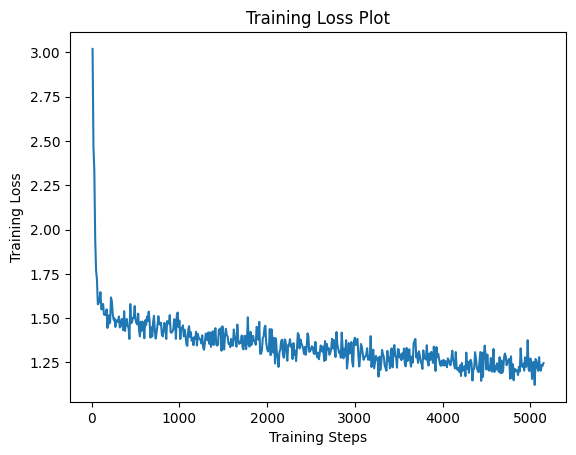

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

training_logs = trainer.state.log_history

loss = []
step = []
for i, log in enumerate(training_logs):
  if (i + 1) % len(training_logs) == 0:
    break
  else:
    loss.append(log['loss'])
    step.append(log['step'])

# print(step)
# print(loss)

# Plot the loss
plt.plot(step, loss)
plt.xlabel("Training Steps")
plt.ylabel("Training Loss")
plt.title("Training Loss Plot")
plt.show()
